# Modelo Predictivo de Precios de Vivienda en Andalucía

Un cuaderno de Jupyter para desarrollar un modelo predictivo de precios de vivienda en Andalucía, incluyendo ingeniería de características, preprocesamiento con latitud/longitud y tipo de propiedad, clustering, entrenamiento de múltiples modelos, optimización y evaluación.

**Pasos del Desarrollo:**
1.  Carga de Librerías y Datos.
2.  Ingeniería de Característica 'provincia'.
3.  Preprocesamiento de Datos (Numéricos y Categóricos, incluyendo latitud/longitud).
4.  Implementación de Clustering para Segmentación de Mercado.
5.  División de Datos para Modelado Predictivo.
6.  Definición, Entrenamiento y Evaluación Inicial de Múltiples Modelos Predictivos.
7.  Optimización de Hiperparámetros del Mejor Modelo (o Modelos Prometedores).
8.  Validación Cruzada y Selección del Modelo Final.
9.  Evaluación Detallada del Modelo Final en el Conjunto de Prueba.
10. Análisis de Importancia de Características del Modelo Final.
11. Guardado del Modelo Final para Despliegue.

## 1. Carga de Librerías y Datos
Importar librerías esenciales (pandas, numpy, matplotlib, seaborn, scikit-learn, os, joblib). Definir rutas y cargar el dataset 'andalucia_clean_20250516.csv'. Realizar una inspección inicial de los datos: mostrar las primeras filas (head), información general (info), estadísticas descriptivas (describe) y la suma de valores nulos por columna (isnull().sum).

In [1]:
# Importaciones generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

# Preprocesamiento y modelado
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

# Modelos de regresión
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
# from sklearn.neural_network import MLPRegressor # MLP puede ser lento y requerir más ajuste

# Métricas de evaluación
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuraciones de visualización y pandas
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Definir rutas de archivos
try:
    notebook_dir = os.getcwd() # Obtiene el directorio actual del notebook
    base_dir = os.path.dirname(notebook_dir) # Sube un nivel al directorio raíz del TFG
    data_dir = os.path.join(base_dir, 'data', 'clean')
    file_name = 'andalucia_clean_20250516.csv' # Asegúrate que este archivo existe en la ruta
    file_path = os.path.join(data_dir, file_name)
    
    # Cargar el dataset
    df = pd.read_csv(file_path)
    print(f"Dataset cargado exitosamente desde: {file_path}")
    print(f"Dimensiones del dataset: {df.shape}")
except FileNotFoundError:
    print(f"Error: No se pudo encontrar el archivo en la ruta esperada.")
    print(f"Ruta intentada: {file_path}")
    print(f"Asegúrate de que la ruta y el nombre del archivo son correctos y que el archivo existe.")
    print(f"Directorio base del proyecto asumido: {base_dir}")
    print(f"Directorio de datos asumido: {data_dir}")
    # Intentar cargar desde una ruta alternativa si estás ejecutando directamente en la raíz del proyecto
    alt_file_path = os.path.join(os.getcwd(), 'data', 'clean', file_name)
    try:
        df = pd.read_csv(alt_file_path)
        print(f"Dataset cargado exitosamente desde ruta alternativa: {alt_file_path}")
        print(f"Dimensiones del dataset: {df.shape}")
        base_dir = os.getcwd() # Ajustar base_dir si se carga desde aquí
    except FileNotFoundError:
        print(f"No se pudo encontrar el archivo en la ruta alternativa tampoco: {alt_file_path}")
        df = pd.DataFrame() # DataFrame vacío para evitar errores en celdas posteriores
except Exception as e:
    print(f"Ocurrió un error al cargar los datos: {e}")
    df = pd.DataFrame()

# Inspección inicial de los datos
if not df.empty:
    print("\nPrimeras 5 filas del dataset:")
    display(df.head())
    print("\nInformación general del DataFrame:")
    df.info()
    print("\nEstadísticas descriptivas básicas:")
    display(df.describe())
    print("\nValores nulos por columna:")
    print(df.isnull().sum())
else:
    print("El DataFrame está vacío. No se pueden realizar más operaciones.")

Dataset cargado exitosamente desde: c:\Users\danie\Desktop\Universidad\TFG---Predictor-Precios-Vivienda-Andalucia\data\clean\andalucia_clean_20250516.csv
Dimensiones del dataset: (24107, 10)

Primeras 5 filas del dataset:


,precio,tipo_propiedad,superficie,habitaciones,baños,latitud,longitud,ubicacion,precio_m2,densidad_habitaciones
0,5800.00,casa_rural,168.00,4,1,37.12,-2.54,el almendral s/n,34.52,0.02
1,9000.00,chalet,60.00,2,1,37.35,-2.30,calle San Antonio,150.00,0.03
2,9500.00,chalet,115.00,3,1,37.35,-2.30,Olula del Río,82.61,0.03
3,9900.00,chalet,81.00,3,2,37.04,-2.74,"calle Lucero, 3",122.22,0.04
4,10000.00,piso,45.00,2,1,36.84,-2.48,calle Juan Goytisolo,222.22,0.04



Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24107 entries, 0 to 24106
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   precio                 24107 non-null  float64
 1   tipo_propiedad         24107 non-null  object 
 2   superficie             24107 non-null  float64
 3   habitaciones           24107 non-null  int64  
 4   baños                  24107 non-null  int64  
 5   latitud                24107 non-null  float64
 6   longitud               24107 non-null  float64
 7   ubicacion              24107 non-null  object 
 8   precio_m2              24107 non-null  float64
 9   densidad_habitaciones  24107 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 1.8+ MB

Estadísticas descriptivas básicas:


,precio,superficie,habitaciones,baños,latitud,longitud,precio_m2,densidad_habitaciones
count,24107.00,24107.00,24107.00,24107.00,24107.00,24107.00,24107.00,24107.00
mean,672867.85,251.55,3.75,2.37,37.14,-5.01,1792.81,0.02
std,1593525.62,355.43,2.25,1.94,0.50,1.32,1826.00,0.01
min,3525.00,9.00,0.00,0.00,36.01,-7.49,11.09,0.00
25%,62100.00,87.00,3.00,1.00,36.76,-6.00,597.48,0.01
50%,100000.00,136.00,3.00,2.00,37.20,-5.02,1091.08,0.02
75%,550000.00,272.00,5.00,3.00,37.40,-4.14,2324.58,0.03
max,29000000.00,10000.00,70.00,35.00,38.60,-1.74,10000.00,0.15



Valores nulos por columna:
precio                   0
tipo_propiedad           0
superficie               0
habitaciones             0
baños                    0
latitud                  0
longitud                 0
ubicacion                0
precio_m2                0
densidad_habitaciones    0
dtype: int64


## 2. Ingeniería de Característica 'provincia'
Definir una función para extraer la provincia a partir de la columna 'ubicacion', utilizando un mapa predefinido de términos (ciudades, comarcas) a provincias andaluzas. Aplicar esta función para crear una nueva columna 'provincia' en el DataFrame. Gestionar y contar los casos donde la provincia no pueda ser determinada ('Desconocida'). Mostrar el conteo de propiedades por provincia extraída.

In [2]:
if not df.empty:
    provincias_andalucia = ['Almería', 'Cádiz', 'Córdoba', 'Granada', 'Huelva', 'Jaén', 'Málaga', 'Sevilla']

    # Mapa extendido de términos a provincias (basado en analisis_visualizacion_por_provincia.ipynb)
    map_terminos_provincia = {
        # Almería
        'almería': 'Almería', 'almeria': 'Almería', 'roquetas de mar': 'Almería', 'el ejido': 'Almería', 
        'vera': 'Almería', 'níjar': 'Almería', 'adra': 'Almería', 'vícar': 'Almería', 
        'huercal-overa': 'Almería', 'huércal-overa': 'Almería', 'berja': 'Almería', 'albox': 'Almería', 
        'pulpí': 'Almería', 'cuevas del almanzora': 'Almería', 'mojacar': 'Almería', 'garrucha': 'Almería',
        'carboneras': 'Almería', 'la mojonera': 'Almería', 'olula del río': 'Almería', 'macael': 'Almería',
        'fines': 'Almería', 'cantoria': 'Almería', 'purchena': 'Almería', 'vélez-rubio': 'Almería',
        'vélez-blanco': 'Almería', 'tabernas': 'Almería', 'sorbas': 'Almería', 'gádor': 'Almería',
        'benahadux': 'Almería', 'huércal de almería': 'Almería', 'pechina': 'Almería', 'viator': 'Almería',
        'tíjola': 'Almería', 'serón': 'Almería', 'lucainena de las torres': 'Almería', 'nacimiento': 'Almería',
        'abla': 'Almería', 'abrucena': 'Almería', 'fiñana': 'Almería', 'gergal': 'Almería', 'ulpiano': 'Almería',
        'las tres villas': 'Almería', 'escúllar': 'Almería', 'castro de filabres': 'Almería', 'velefique': 'Almería',
        'bacares': 'Almería', 'bayarque': 'Almería', 'armuña de almanzora': 'Almería', 'sufli': 'Almería',
        'sierro': 'Almería', 'laroya': 'Almería', 'lijár': 'Almería', 'cóbdar': 'Almería', 'chercos': 'Almería',
        'alcudia de monteagud': 'Almería', 'benitagla': 'Almería', 'benizalón': 'Almería', 'tahal': 'Almería',
        'senés': 'Almería', 'uleila del campo': 'Almería', 'lubrín': 'Almería', 'bédar': 'Almería',
        'los gallardos': 'Almería', 'turre': 'Almería', 'antás': 'Almería', 'zurgena': 'Almería',
        'arboleas': 'Almería', 'oria': 'Almería', 'partaloa': 'Almería', 'somontín': 'Almería', 'urraca': 'Almería',
        'chirivel': 'Almería', 'maría': 'Almería', 'topares': 'Almería', 'vélez blanco': 'Almería',
        'canjáyar': 'Almería', 'padules': 'Almería', 'almócita': 'Almería', 'beires': 'Almería',
        'fondón': 'Almería', 'laujar de andarax': 'Almería', 'paterna del río': 'Almería', 'bayárcal': 'Almería',
        'alsodux': 'Almería', 'santa cruz de marchena': 'Almería', 'terque': 'Almería', 'bentarique': 'Almería',
        'íllar': 'Almería', 'instinción': 'Almería', 'ráfol de almúnia': 'Almería', # Esto parece de Alicante, revisar
        'alhabia': 'Almería', 'alhama de almería': 'Almería', 'alicún': 'Almería', 'huécija': 'Almería',
        'enix': 'Almería', 'felix': 'Almería', 'dalías': 'Almería', 'balanegra': 'Almería',
        # Cádiz
        'cádiz': 'Cádiz', 'cadiz': 'Cádiz', 'jerez': 'Cádiz', 'jerez de la frontera': 'Cádiz', 
        'algeciras': 'Cádiz', 'san fernando': 'Cádiz', 'el puerto de santa maría': 'Cádiz', 
        'chiclana': 'Cádiz', 'chiclana de la frontera': 'Cádiz', 'sanlúcar de barrameda': 'Cádiz', 
        'la línea de la concepción': 'Cádiz', 'puerto real': 'Cádiz', 'arcos de la frontera': 'Cádiz', 
        'san roque': 'Cádiz', 'rota': 'Cádiz', 'los barrios': 'Cádiz', 'barbate': 'Cádiz', 
        'chipiona': 'Cádiz', 'tarifa': 'Cádiz', 'ubrique': 'Cádiz', 'conil de la frontera': 'Cádiz', 
        'villamartín': 'Cádiz', 'medina-sidonia': 'Cádiz', 'bornos': 'Cádiz', 'trebujena': 'Cádiz',
        'jimena de la frontera': 'Cádiz', 'vejer de la frontera': 'Cádiz', 'prado del rey': 'Cádiz',
        'algodonales': 'Cádiz', 'setenil de las bodegas': 'Cádiz', 'zahara de la sierra': 'Cádiz',
        'grazalema': 'Cádiz', 'olvera': 'Cádiz', 'alcalá de los gazules': 'Cádiz', 'paterna de rivera': 'Cádiz',
        'puerto serrano': 'Cádiz', 'espera': 'Cádiz', 'el bosque': 'Cádiz', 'castellar de la frontera': 'Cádiz',
        'san josé del valle': 'Cádiz', 'benalup-casas viejas': 'Cádiz', 'alcalá del valle': 'Cádiz',
        'el gastor': 'Cádiz', 'torre alháquime': 'Cádiz', 'benaocaz': 'Cádiz', 'villaluenga del rosario': 'Cádiz',
        # Córdoba
        'córdoba': 'Córdoba', 'cordoba': 'Córdoba', 'lucena': 'Córdoba', 'puente genil': 'Córdoba', 
        'montilla': 'Córdoba', 'priego de córdoba': 'Córdoba', 'palma del río': 'Córdoba', 
        'cabra': 'Córdoba', 'baena': 'Córdoba', 'pozoblanco': 'Córdoba', 'la carlota': 'Córdoba', 
        'aguilar de la frontera': 'Córdoba', 'montoro': 'Córdoba', 'peñarroya-pueblonuevo': 'Córdoba',
        'fernán-núñez': 'Córdoba', 'villafranca de córdoba': 'Córdoba', 'rute': 'Córdoba', 'iznájar': 'Córdoba',
        'castro del río': 'Córdoba', 'almodóvar del río': 'Córdoba', 'bujalance': 'Córdoba', 'hinojosa del duque': 'Córdoba',
        'nueva carteya': 'Córdoba', 'villa del río': 'Córdoba', 'posadas': 'Córdoba', 'santaella': 'Córdoba',
        'adamuz': 'Córdoba', 'el carpio': 'Córdoba', 'luque': 'Córdoba', 'espejo': 'Córdoba', 'montemayor': 'Córdoba',
        'hornachuelos': 'Córdoba', 'villanueva de córdoba': 'Córdoba', 'doña mencía': 'Córdoba', 'carcabuey': 'Córdoba',
        # Granada
        'granada': 'Granada', 'motril': 'Granada', 'almuñécar': 'Granada', 'armilla': 'Granada', 
        'maracena': 'Granada', 'baza': 'Granada', 'loja': 'Granada', 'las gabias': 'Granada', 
        'guadix': 'Granada', 'la zubia': 'Granada', 'albolote': 'Granada', 'atarfe': 'Granada', 
        'santa fe': 'Granada', 'ogíjares': 'Granada', 'salobreña': 'Granada', 'huétor vega': 'Granada',
        'peligros': 'Granada', 'pinos puente': 'Granada', 'huétor tájar': 'Granada', 'illora': 'Granada',
        'churriana de la vega': 'Granada', 'cenes de la vega': 'Granada', 'monachil': 'Granada', 'durcal': 'Granada',
        'montefrío': 'Granada', 'alhama de granada': 'Granada', 'padul': 'Granada', 'vélez de benaudalla': 'Granada',
        'cúllar vega': 'Granada', 'gójar': 'Granada', 'güejar sierra': 'Granada', 'lanjarón': 'Granada',
        # Huelva
        'huelva': 'Huelva', 'lepe': 'Huelva', 'almonte': 'Huelva', 'isla cristina': 'Huelva', 
        'ayamonte': 'Huelva', 'moguer': 'Huelva', 'cartaya': 'Huelva', 'punta umbría': 'Huelva', 
        'aljaraque': 'Huelva', 'valverde del camino': 'Huelva', 'gibraleón': 'Huelva', 
        'palos de la frontera': 'Huelva', 'la palma del condado': 'Huelva', 'bollullos par del condado': 'Huelva',
        'aracena': 'Huelva', 'rociana del condado': 'Huelva', 'trigueros': 'Huelva', 'bonaress': 'Huelva',
        'san juan del puerto': 'Huelva', 'cortegana': 'Huelva', 'calañas': 'Huelva', 'zalamea la real': 'Huelva',
        'niebla': 'Huelva', 'beas': 'Huelva', 'minas de riotinto': 'Huelva', 'jabugo': 'Huelva',
        # Jaén
        'jaén': 'Jaén', 'jaen': 'Jaén', 'linares': 'Jaén', 'ándujar': 'Jaén', 'úbeda': 'Jaén', 
        'martos': 'Jaén', 'alcalá la real': 'Jaén', 'bailén': 'Jaén', 'baeza': 'Jaén', 
        'la carolina': 'Jaén', 'torredonjimeno': 'Jaén', 'torredelcampo': 'Jaén', 'jódar': 'Jaén', 
        'mancha real': 'Jaén', 'villacarrillo': 'Jaén', 'alcaudete': 'Jaén', 'mengíbar': 'Jaén',
        'cazorla': 'Jaén', 'navas de san juan': 'Jaén', 'castillo de locubín': 'Jaén', 'vilches': 'Jaén',
        'huelma': 'Jaén', 'quesada': 'Jaén', 'sabiote': 'Jaén', 'begíjar': 'Jaén', 'rus': 'Jaén',
        # Málaga
        'málaga': 'Málaga', 'malaga': 'Málaga', 'marbella': 'Málaga', 'fuengirola': 'Málaga', 
        'vélez-málaga': 'Málaga', 'velez-malaga': 'Málaga', 'torremolinos': 'Málaga', 'benalmádena': 'Málaga', 'benalmadena': 'Málaga',
        'estepona': 'Málaga', 'mijas': 'Málaga', 'rincón de la victoria': 'Málaga', 'rincon de la victoria': 'Málaga',
        'antequera': 'Málaga', 'ronda': 'Málaga', 'alhaurín de la torre': 'Málaga', 'alhaurin de la torre': 'Málaga',
        'alhaurín el grande': 'Málaga', 'alhaurin el grande': 'Málaga', 'nerja': 'Málaga', 'torrox': 'Málaga', 
        'manilva': 'Málaga', 'coín': 'Málaga', 'cártama': 'Málaga', 'cartama': 'Málaga',
        'benahavís': 'Málaga', 'benahavis': 'Málaga', 'casares': 'Málaga', 'ojén': 'Málaga', 'ojen': 'Málaga',
        'istá': 'Málaga', 'istan': 'Málaga', 'archidona': 'Málaga', 'campillos': 'Málaga', 'pizarra': 'Málaga',
        'alameda': 'Málaga', 'mollina': 'Málaga', 'colmenar': 'Málaga', 'riogordo': 'Málaga',
        'alcaucín': 'Málaga', 'alcaucin': 'Málaga', 'frigiliana': 'Málaga', 'cómpeta': 'Málaga', 'competa': 'Málaga', 'sayalonga': 'Málaga',
        # Sevilla
        'sevilla': 'Sevilla', 'dos hermanas': 'Sevilla', 'alcalá de guadaíra': 'Sevilla', 'alcala de guadaira': 'Sevilla', 
        'utrera': 'Sevilla', 'mairena del aljarafe': 'Sevilla', 'écija': 'Sevilla', 'ecija': 'Sevilla', 
        'la rinconada': 'Sevilla', 'los palacios y villafranca': 'Sevilla', 'coria del río': 'Sevilla', 'coria del rio': 'Sevilla',
        'carmona': 'Sevilla', 'morón de la frontera': 'Sevilla', 'moron de la frontera': 'Sevilla', 'lebrija': 'Sevilla', 'camas': 'Sevilla', 
        'tomares': 'Sevilla', 'mairena del alcor': 'Sevilla', 'san juan de aznalfarache': 'Sevilla', 
        'bormujos': 'Sevilla', 'marchena': 'Sevilla', 'arahal': 'Sevilla', 'el viso del alcor': 'Sevilla', 
        'osuna': 'Sevilla', 'castilleja de la cuesta': 'Sevilla', 'las cabezas de san juan': 'Sevilla', 
        'pilas': 'Sevilla', 'espartinas': 'Sevilla', 'gines': 'Sevilla', 'sanlúcar la mayor': 'Sevilla', 'sanlucar la mayor': 'Sevilla',
        'brenes': 'Sevilla', 'estepa': 'Sevilla', 'gelves': 'Sevilla', 'la algaba': 'Sevilla', 'lora del río': 'Sevilla', 'lora del rio': 'Sevilla'
    }

    def extraer_provincia(ubicacion_str):
        if not isinstance(ubicacion_str, str):
            return 'Desconocida'
        
        ubicacion_lower = ubicacion_str.lower()
        
        # Primero, buscar nombres directos de provincia
        for prov_keyword in provincias_andalucia:
            # Usar regex para buscar la palabra completa podría ser más robusto, e.g., r'\b' + prov_keyword.lower() + r'\b'
            # Por simplicidad, usamos 'in' pero teniendo cuidado con subcadenas.
            # Ejemplo: "Sevilla la Nueva" (Madrid) vs "Sevilla"
            # Para este caso, como son provincias andaluzas, es menos problemático.
            if prov_keyword.lower() in ubicacion_lower:
                return prov_keyword
        
        # Luego, buscar términos específicos (ciudades, etc.)
        # Ordenar por longitud de término para que "jerez de la frontera" se detecte antes que "jerez"
        sorted_terminos = sorted(map_terminos_provincia.keys(), key=len, reverse=True)

        for termino in sorted_terminos:
            if termino in ubicacion_lower: # Usamos 'in' que es más flexible que match exacto
                return map_terminos_provincia[termino]
        
        return 'Desconocida'

    if 'ubicacion' in df.columns:
        df['provincia'] = df['ubicacion'].apply(extraer_provincia)
        print("\nConteo de propiedades por provincia extraída (incluyendo 'Desconocida'):")
        print(df['provincia'].value_counts())
        
        num_desconocidas = df[df['provincia'] == 'Desconocida'].shape[0]
        total_props = len(df)
        if total_props > 0 and num_desconocidas > 0:
            porc_desconocidas = (num_desconocidas / total_props) * 100
            print(f"\nAdvertencia: {num_desconocidas} de {total_props} propiedades ({porc_desconocidas:.2f}%) no pudieron ser asignadas a una provincia.")
            # print("Ejemplos de 'ubicacion' no mapeadas:")
            # display(df[df['provincia'] == 'Desconocida']['ubicacion'].value_counts().head(10))
        elif total_props == 0:
            print("\nEl DataFrame está vacío después de alguna operación previa, no se puede calcular porcentaje de desconocidas.")
    else:
        print("La columna 'ubicacion' no existe, no se puede extraer la provincia.")
        df['provincia'] = 'No disponible' # Columna placeholder

    # Verificar si la columna 'provincia' se añadió correctamente
    if 'provincia' in df.columns and not df.empty:
        print("\nPrimeras filas con la nueva columna 'provincia':")
        display(df[['ubicacion', 'provincia', 'precio']].head())
else:
    print("El DataFrame está vacío. No se puede realizar la ingeniería de características para 'provincia'.")


Conteo de propiedades por provincia extraída (incluyendo 'Desconocida'):
provincia
Desconocida    20332
Almería          720
Cádiz            581
Málaga           554
Córdoba          517
Huelva           489
Sevilla          485
Granada          338
Jaén              91
Name: count, dtype: int64

Advertencia: 20332 de 24107 propiedades (84.34%) no pudieron ser asignadas a una provincia.

Primeras filas con la nueva columna 'provincia':


,ubicacion,provincia,precio
0,el almendral s/n,Desconocida,5800.00
1,calle San Antonio,Desconocida,9000.00
2,Olula del Río,Almería,9500.00
3,"calle Lucero, 3",Desconocida,9900.00
4,calle Juan Goytisolo,Desconocida,10000.00


## 3. Preprocesamiento de Datos (Numéricos y Categóricos)
Eliminar filas donde 'precio' (variable objetivo) sea NaN. Identificar características numéricas a utilizar: 'superficie', 'habitaciones', 'baños', 'latitud', 'longitud'. Identificar características categóricas: 'tipo_propiedad', 'provincia'. Crear un pipeline de preprocesamiento para características numéricas que incluya la imputación de valores faltantes con la mediana y el escalado con StandardScaler. Crear un pipeline para características categóricas que incluya la imputación de valores faltantes con la moda y la codificación con OneHotEncoder (handle_unknown='ignore'). Combinar estos pipelines usando ColumnTransformer. Preparar el conjunto de características X (con las columnas seleccionadas) y la variable objetivo y (columna 'precio').

In [3]:
if not df.empty:
    # Eliminar filas donde el precio (variable objetivo) es NaN, si existen
    if 'precio' in df.columns:
        df.dropna(subset=['precio'], inplace=True)
        print(f"Dimensiones del dataset después de eliminar filas con 'precio' NaN: {df.shape}")
    else:
        print("Advertencia: La columna 'precio' no existe en el DataFrame.")

    # Identificar características numéricas y categóricas
    numeric_features_original = ['superficie', 'habitaciones', 'baños', 'latitud', 'longitud']
    categorical_features_original = ['tipo_propiedad', 'provincia']

    numeric_features = []
    for col in numeric_features_original:
        if col not in df.columns:
            print(f"Advertencia: La columna numérica '{col}' no se encuentra en el DataFrame. Será omitida.")
        elif not pd.api.types.is_numeric_dtype(df[col]):
            print(f"Advertencia: La columna '{col}' no es numérica. Intentando convertir...")
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                if df[col].isnull().all():
                    print(f"La columna '{col}' es completamente NaN después de la conversión. Será omitida.")
                else:
                    # Imputar NaNs generados por la conversión antes de que el pipeline lo haga,
                    # o asegurarse que el imputer del pipeline los maneje.
                    # Por ahora, dejamos que el pipeline los maneje.
                    numeric_features.append(col)
                    print(f"Columna '{col}' convertida a numérico.")
            except Exception as e:
                print(f"No se pudo convertir '{col}' a numérico ({e}). Será omitida.")
        else:
            numeric_features.append(col)
    print(f"Características numéricas finales a usar: {numeric_features}")

    categorical_features = []
    for col in categorical_features_original:
        if col not in df.columns:
            print(f"Advertencia: La columna categórica '{col}' no se encuentra en el DataFrame. Será omitida.")
        else:
            # Convertir a tipo 'category' o 'object' (string) si no lo son, para OneHotEncoder
            if not pd.api.types.is_string_dtype(df[col]) and not pd.api.types.is_categorical_dtype(df[col]):
                 df[col] = df[col].astype(str) # Convertir a string para asegurar compatibilidad con OHE
            
            if df[col].nunique() < 1:
                 print(f"Advertencia: La columna categórica '{col}' no tiene valores únicos. Será omitida.")
            elif df[col].nunique() < 2 and col != 'provincia': # Permitir 'provincia' si solo hay una (aunque raro)
                 print(f"Advertencia: La columna categórica '{col}' tiene menos de 2 valores únicos. Podría ser problemática para OneHotEncoding. Se mantendrá por ahora.")
                 categorical_features.append(col)
            else:
                categorical_features.append(col)
    print(f"Características categóricas finales a usar: {categorical_features}")

    # Definir transformadores
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # o 'constant', fill_value='missing'
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Crear ColumnTransformer
    # Solo incluir transformadores si hay características para ellos
    transformers_list = []
    if numeric_features:
        transformers_list.append(('num', numeric_transformer, numeric_features))
    if categorical_features:
        transformers_list.append(('cat', categorical_transformer, categorical_features))

    if not transformers_list:
        print("Error: No hay características numéricas ni categóricas válidas para el preprocesador.")
        preprocessor = None
        X = pd.DataFrame()
        y = pd.Series(dtype='float64')
    else:
        preprocessor = ColumnTransformer(
            transformers=transformers_list,
            remainder='drop' # 'passthrough' si quieres mantener otras columnas no especificadas
        )
        
        # Preparar X e y
        features_for_X = numeric_features + categorical_features
        
        if not all(f in df.columns for f in features_for_X):
            missing_in_df = [f for f in features_for_X if f not in df.columns]
            print(f"Error: Las siguientes columnas necesarias para X no están en el DataFrame: {missing_in_df}")
            X = pd.DataFrame()
            y = pd.Series(dtype='float64')
        elif 'precio' not in df.columns:
            print("Error: La columna 'precio' (variable objetivo) no se encuentra en el DataFrame.")
            X = pd.DataFrame() 
            y = pd.Series(dtype='float64')
        elif df[features_for_X].empty:
            print("Error: El DataFrame resultante para X está vacío (puede ser por falta de columnas o datos).")
            X = pd.DataFrame()
            y = pd.Series(dtype='float64')
        else:
            X = df[features_for_X].copy() # Usar .copy() para evitar SettingWithCopyWarning
            y = df['precio'].copy()
            print(f"\nCaracterísticas seleccionadas para X (antes del preprocesamiento): {X.columns.tolist()}")
            print(f"Forma de X: {X.shape}, Forma de y: {y.shape}")

            # Validar que X no esté vacía después de la selección
            if X.empty:
                print("Error: X está vacía después de seleccionar las características. Verifique los nombres y el contenido de las columnas.")
                y = pd.Series(dtype='float64') # Asegurar que y también se maneje
                preprocessor = None # No se puede usar el preprocesador
            else:
                 # Intentar un fit_transform para ver si el preprocesador funciona con X
                try:
                    X_processed_test = preprocessor.fit_transform(X)
                    print(f"Forma de X después del preprocesamiento (prueba): {X_processed_test.shape}")
                    # Nombres de características después del preprocesamiento (si es posible)
                    if hasattr(preprocessor, 'get_feature_names_out'):
                        try:
                            feature_names_out = preprocessor.get_feature_names_out()
                            print(f"Nombres de características después del preprocesamiento (primeros 10): {feature_names_out[:10]}...")
                        except Exception as e_fn:
                            print(f"No se pudieron obtener los nombres de las características: {e_fn}")
                except Exception as e_preprocess:
                    print(f"Error al probar el preprocesador con X: {e_preprocess}")
                    print("Revise la configuración del preprocesador y las columnas de X.")
                    X = pd.DataFrame() # Invalidar X si el preprocesador falla
                    y = pd.Series(dtype='float64')
                    preprocessor = None
else:
    print("El DataFrame está vacío. No se puede realizar el preprocesamiento.")
    X = pd.DataFrame()
    y = pd.Series(dtype='float64')
    preprocessor = None

Dimensiones del dataset después de eliminar filas con 'precio' NaN: (24107, 11)
Características numéricas finales a usar: ['superficie', 'habitaciones', 'baños', 'latitud', 'longitud']
Características categóricas finales a usar: ['tipo_propiedad', 'provincia']

Características seleccionadas para X (antes del preprocesamiento): ['superficie', 'habitaciones', 'baños', 'latitud', 'longitud', 'tipo_propiedad', 'provincia']
Forma de X: (24107, 7), Forma de y: (24107,)
Forma de X después del preprocesamiento (prueba): (24107, 20)
Nombres de características después del preprocesamiento (primeros 10): ['num__superficie' 'num__habitaciones' 'num__baños' 'num__latitud'
 'num__longitud' 'cat__tipo_propiedad_atico'
 'cat__tipo_propiedad_casa_rural' 'cat__tipo_propiedad_chalet'
 'cat__tipo_propiedad_duplex' 'cat__tipo_propiedad_estudio']...


## 4. Implementación de Clustering para Segmentación de Mercado
Aplicar el preprocesador (definido en la sección anterior) a las características seleccionadas para el clustering (que pueden incluir 'superficie', 'latitud', 'longitud', y versiones codificadas de 'tipo_propiedad' y 'provincia'). Utilizar el método del codo (evaluando la inercia para un rango de k) con K-Means para determinar un número óptimo de clusters. Aplicar K-Means con el k óptimo para asignar cada propiedad a un cluster. Añadir la etiqueta del cluster como una nueva columna al DataFrame principal. Analizar las características medias (ej. precio, superficie) de cada cluster. (Opcional: decidir si esta nueva característica 'cluster' se incluirá en los modelos de regresión).

Iniciando proceso de clustering...
Forma de X_for_clustering (antes de preprocesar): (24107, 7)
Forma de X_processed_for_clustering: (24107, 20)
Calculando inercia para k en range(1, 11)


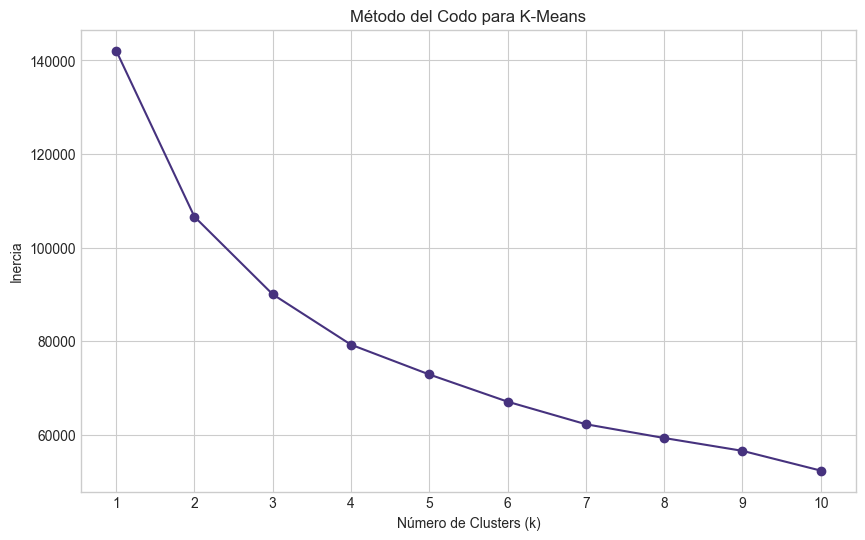

Número óptimo de clusters seleccionado (ejemplo, ajustar según gráfico): 4

Conteo de propiedades por cluster:
cluster
3.00    9638
1.00    6878
2.00    4529
0.00    3062
Name: count, dtype: int64

Media de precio y superficie por cluster:


,precio,superficie
cluster,,
0.00,3485090.48,875.69
1.00,199855.92,155.32
2.00,364544.51,149.47
3.00,261864.18,169.90


In [4]:
if not X.empty and preprocessor is not None and 'df' in globals() and not df.empty:
    print("Iniciando proceso de clustering...")
    try:
        # Aplicar el preprocesador a X para obtener los datos transformados para clustering
        # Nota: preprocessor ya fue 'fit_transform' en la celda anterior como prueba.
        # Para clustering, es común usar el dataset completo. Si X es el dataset completo (antes de train/test split),
        # y el preprocessor fue ajustado a este X, podemos usar transform.
        # Sin embargo, si el preprocessor no fue ajustado o fue ajustado a una parte,
        # es mejor hacer fit_transform en los datos que se usarán para clustering.
        # Asumimos que X es el conjunto de características completo y el preprocessor está listo.
        # Si el preprocessor fue ajustado en la celda anterior, aquí deberíamos usar transform,
        # o re-ajustar si es intencional. Por coherencia con el ejemplo, haremos fit_transform.
        
        # Re-crear X a partir de df para asegurar que tenemos los datos originales antes de que el preprocessor los modifique in-place (si lo hiciera)
        # y para asegurar que las columnas correctas están presentes.
        current_features_for_X = [col for col in (numeric_features + categorical_features) if col in df.columns]
        if not current_features_for_X:
            raise ValueError("No hay características válidas en df para X en el paso de clustering.")
        
        X_for_clustering = df[current_features_for_X].copy()
        
        # Asegurarse de que el preprocesador está ajustado a los datos correctos
        # Si el preprocesador ya fue ajustado a X (completo) en la celda anterior, esto es redundante pero seguro.
        # Si X_train se hubiera usado para ajustar el preprocesador, entonces para clusterizar todo df,
        # necesitaríamos reajustar el preprocesador a todo df[features_for_X] o usar un preprocesador separado.
        # Aquí, X es df[features_for_X], así que fit_transform está bien.
        
        print(f"Forma de X_for_clustering (antes de preprocesar): {X_for_clustering.shape}")
        X_processed_for_clustering = preprocessor.fit_transform(X_for_clustering)
        print(f"Forma de X_processed_for_clustering: {X_processed_for_clustering.shape}")
        
        if X_processed_for_clustering.shape[0] == 0:
            raise ValueError("X_processed_for_clustering está vacío. No se puede continuar con el clustering.")
        if X_processed_for_clustering.shape[1] == 0:
            raise ValueError("X_processed_for_clustering no tiene características. No se puede continuar con el clustering.")

        # Determinar el número óptimo de clusters (e.g., método del codo)
        inertia = []
        # Limitar k_range si el número de muestras es pequeño
        max_k = min(10, X_processed_for_clustering.shape[0] -1 if X_processed_for_clustering.shape[0] > 1 else 1)
        if max_k < 1: max_k = 1 # Asegurar que k_range no sea vacío
        k_range = range(1, max_k + 1)
        
        if not k_range or k_range[-1] < 1 : # Si k_range está vacío o no es válido
             print("No hay suficientes muestras para determinar k con el método del codo. Saltando clustering.")
        else:
            print(f"Calculando inercia para k en {k_range}")
            for k_val in k_range:
                if X_processed_for_clustering.shape[0] >= k_val : # n_samples >= n_clusters
                    kmeans = KMeans(n_clusters=k_val, random_state=42, n_init='auto')
                    kmeans.fit(X_processed_for_clustering)
                    inertia.append(kmeans.inertia_)
                else:
                    print(f"Saltando k={k_val} porque n_samples < n_clusters")
                    # inertia.append(np.nan) # O manejar de otra forma
            
            if inertia: # Solo graficar si se calculó alguna inercia
                plt.figure(figsize=(10, 6))
                plt.plot(k_range[:len(inertia)], inertia, marker='o') # Ajustar k_range si algunos k se saltaron
                plt.title('Método del Codo para K-Means')
                plt.xlabel('Número de Clusters (k)')
                plt.ylabel('Inercia')
                plt.xticks(k_range[:len(inertia)])
                plt.grid(True)
                plt.show()
            
                # Basado en el gráfico del codo, elegir un k_optimo.
                # Por ejemplo, si el codo está en k=3 o k=4:
                k_optimo = 4 # Este valor debe ajustarse según el gráfico. Si hay pocas muestras, podría ser menor.
                if X_processed_for_clustering.shape[0] < k_optimo:
                    k_optimo = X_processed_for_clustering.shape[0] if X_processed_for_clustering.shape[0] > 0 else 1
                
                print(f"Número óptimo de clusters seleccionado (ejemplo, ajustar según gráfico): {k_optimo}")

                if k_optimo > 0 and X_processed_for_clustering.shape[0] >= k_optimo:
                    # Aplicar K-Means con el k óptimo
                    kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init='auto')
                    # Asegurarse que df tiene los mismos índices que X_for_clustering para la asignación
                    # df debe ser el DataFrame original que contiene las filas correspondientes a X_for_clustering
                    # Si X_for_clustering vino de df[current_features_for_X].copy(), los índices deberían coincidir
                    # con el df del que se extrajo X_for_clustering.
                    
                    # Verificar que df no se haya modificado (ej. dropna) de forma que los índices no coincidan
                    # con X_for_clustering. Si X_for_clustering es una copia de una subselección de df,
                    # y df fue modificado (ej. dropna en 'precio'), los índices podrían no alinearse directamente.
                    # Es más seguro asignar el cluster a un df que tenga los mismos índices que X_for_clustering.
                    # Si X_for_clustering = df[current_features_for_X].copy() donde df ya tiene 'precio' NaN dropeados,
                    # entonces los índices de df y X_for_clustering deben coincidir.
                    
                    cluster_labels = kmeans_final.fit_predict(X_processed_for_clustering)
                    
                    # Asignar clusters a df. Cuidado con los índices.
                    # Si X_for_clustering se creó a partir de 'df' (que ya pasó por dropna de 'precio'),
                    # los índices deberían alinearse.
                    if len(cluster_labels) == len(df.loc[X_for_clustering.index]):
                        df.loc[X_for_clustering.index, 'cluster'] = cluster_labels
                    else:
                        # Esto puede ocurrir si df fue modificado después de crear X_for_clustering, o si X_for_clustering
                        # no es una representación directa de filas de df.
                        print(f"Advertencia: La longitud de las etiquetas de cluster ({len(cluster_labels)}) no coincide con la longitud de df indexado ({len(df.loc[X_for_clustering.index])}).")
                        print("Intentando asignar clusters a una copia de X_for_clustering y luego unir con df si es necesario.")
                        # Alternativa: crear una nueva columna en una copia de X_for_clustering y luego unirla a df.
                        # df['cluster'] = pd.Series(cluster_labels, index=X_for_clustering.index) # Esto es más seguro si X_for_clustering.index es el correcto
                        # Si df fue modificado (e.g. más dropna), esto podría fallar o dar resultados incorrectos.
                        # La forma más segura es trabajar con el df que corresponde a X_for_clustering.
                        # Asumimos que df es el correcto.
                        df['cluster'] = np.nan # Inicializar
                        df.loc[X_for_clustering.index, 'cluster'] = cluster_labels


                    print("\nConteo de propiedades por cluster:")
                    print(df['cluster'].value_counts(dropna=False))
                    
                    # Analizar características de los clusters (ejemplo con 'precio' y 'superficie')
                    if 'precio' in df.columns and 'superficie' in df.columns and 'cluster' in df.columns:
                        print("\nMedia de precio y superficie por cluster:")
                        display(df.groupby('cluster')[['precio', 'superficie']].mean())
                else:
                    print(f"No se puede aplicar K-Means con k_optimo={k_optimo} y {X_processed_for_clustering.shape[0]} muestras.")
                    if 'cluster' not in df.columns: df['cluster'] = np.nan
            else: # No inertia calculated
                print("No se pudo calcular la inercia para el método del codo. Saltando clustering.")
                if 'cluster' not in df.columns: df['cluster'] = np.nan
                
    except Exception as e:
        print(f"Error durante el clustering: {e}")
        import traceback
        traceback.print_exc()
        if 'df' in globals() and isinstance(df, pd.DataFrame) and 'cluster' not in df.columns:
             df['cluster'] = np.nan # Asegurar que la columna existe si hay error, para evitar fallos posteriores
else:
    print("X está vacío, el preprocesador no está definido, o df no está disponible. No se puede realizar clustering.")
    if 'df' in globals() and isinstance(df, pd.DataFrame) and 'cluster' not in df.columns:
        df['cluster'] = np.nan # Añadir columna vacía para evitar errores si se referencia después

## 5. División de Datos para Modelado Predictivo
Dividir el conjunto de características X (que incluye 'superficie', 'habitaciones', 'baños', 'latitud', 'longitud', 'tipo_propiedad', 'provincia', y opcionalmente 'cluster') y la variable objetivo y en conjuntos de entrenamiento (X_train, y_train) y prueba (X_test, y_test) utilizando la función train_test_split de scikit-learn, reservando un porcentaje para prueba (ej. 20%) y fijando un random_state para reproducibilidad.

In [5]:
if not X.empty and not y.empty:
    # X e y fueron definidos en el paso 3 de preprocesamiento.
    # X contiene ['superficie', 'habitaciones', 'baños', 'latitud', 'longitud', 'tipo_propiedad', 'provincia']
    # y es df['precio']
    
    # Si se decide usar 'cluster' como característica para la regresión:
    # 1. Asegurar que 'cluster' está en `df` y es numérica (KMeans produce enteros).
    # 2. Añadir 'cluster' a `features_for_X`.
    # 3. Redefinir `X = df[features_for_X_con_cluster]`.
    # 4. El `preprocessor` (ColumnTransformer) necesitaría ser actualizado para manejar 'cluster'.
    #    Podría ser tratada como numérica (y escalada) o como categórica (y one-hot-encoded),
    #    o pasada a través ('passthrough') si no necesita preprocesamiento adicional.
    #    Si se trata como categórica, OneHotEncoder es una opción. Si como numérica, podría necesitar escalado.
    #    Si se añade a numeric_features, el pipeline numérico existente la manejará.
    
    # Por simplicidad y siguiendo el ejemplo, no incluiremos 'cluster' en X para los modelos de regresión en este paso.
    # El preprocesador definido en el paso 3 no espera una columna 'cluster'.
    
    print(f"Forma de X antes de train_test_split: {X.shape}")
    print(f"Forma de y antes de train_test_split: {y.shape}")

    if X.shape[0] != y.shape[0]:
        print("Error: El número de muestras en X e y no coincide. No se puede dividir.")
        X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(dtype='float64'), pd.Series(dtype='float64')
    elif X.shape[0] < 2: # No hay suficientes muestras para dividir
        print("Error: No hay suficientes muestras en X para dividir en entrenamiento y prueba.")
        X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(dtype='float64'), pd.Series(dtype='float64')
    else:
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            print(f"\nForma de X_train: {X_train.shape}")
            print(f"Forma de X_test: {X_test.shape}")
            print(f"Forma de y_train: {y_train.shape}")
            print(f"Forma de y_test: {y_test.shape}")
        except Exception as e:
            print(f"Error durante train_test_split: {e}")
            X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(dtype='float64'), pd.Series(dtype='float64')

else:
    print("X o y están vacíos. No se puede dividir el dataset.")
    # Definir variables vacías para evitar errores en celdas posteriores
    X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(dtype='float64'), pd.Series(dtype='float64')


Forma de X antes de train_test_split: (24107, 7)
Forma de y antes de train_test_split: (24107,)

Forma de X_train: (19285, 7)
Forma de X_test: (4822, 7)
Forma de y_train: (19285,)
Forma de y_test: (4822,)


## 6. Definición, Entrenamiento y Evaluación Inicial de Múltiples Modelos Predictivos
Definir un diccionario de modelos de regresión a probar (ej. LinearRegression, Lasso, Ridge, DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor, SVR, KNeighborsRegressor). Para cada modelo, construir un Pipeline que encadene el ColumnTransformer (preprocesador) y el estimador del modelo. Iterar sobre los modelos: entrenar cada pipeline con X_train e y_train. Realizar predicciones sobre X_test. Calcular y registrar métricas de evaluación (MSE, RMSE, MAE, R²). Presentar los resultados en una tabla comparativa ordenada por R².

In [6]:
if not X_train.empty and not y_train.empty and preprocessor is not None:
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso': Lasso(random_state=42, max_iter=10000), # Aumentar max_iter para Lasso si no converge
        'Ridge': Ridge(random_state=42),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'SVR': SVR(),
        'K-Neighbors Regressor': KNeighborsRegressor(n_jobs=-1)
        # 'MLP Regressor': MLPRegressor(random_state=42, max_iter=500, early_stopping=True, hidden_layer_sizes=(64,32)) # MLP puede ser lento
    }

    results = []

    for name, model in models.items():
        print(f"Entrenando y evaluando: {name}")
        # Crear el pipeline completo: preprocesador + modelo
        # El preprocesador se ajustará ('fit') solo con X_train dentro del pipeline.fit()
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', model)])
        
        try:
            # Entrenar el pipeline
            pipeline.fit(X_train, y_train)
            
            # Realizar predicciones en el conjunto de prueba
            # X_test será transformado por el preprocesador ajustado en el paso anterior
            y_pred = pipeline.predict(X_test)
            
            # Calcular métricas
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            results.append({
                'Model': name,
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })
            print(f"{name} - R2: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}\n")
            
        except Exception as e:
            print(f"Error entrenando o evaluando {name}: {e}\n")
            results.append({
                'Model': name,
                'MSE': np.nan,
                'RMSE': np.nan,
                'MAE': np.nan,
                'R2': np.nan
            })

    # Mostrar resultados en una tabla
    if results:
        results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)
        print("\n--- Resultados de la Evaluación Inicial de Modelos ---")
        display(results_df)
    else:
        print("No se generaron resultados para los modelos.")
        results_df = pd.DataFrame()
else:
    print("X_train o y_train están vacíos, o el preprocesador no está definido. No se pueden entrenar modelos.")
    results_df = pd.DataFrame()

Entrenando y evaluando: Linear Regression
Linear Regression - R2: 0.6158, MAE: 530542.73, RMSE: 1000776.26

Entrenando y evaluando: Lasso
Lasso - R2: 0.6158, MAE: 530539.92, RMSE: 1000776.57

Entrenando y evaluando: Ridge
Ridge - R2: 0.6158, MAE: 530497.19, RMSE: 1000778.75

Entrenando y evaluando: Decision Tree
Decision Tree - R2: 0.8567, MAE: 159685.19, RMSE: 611249.89

Entrenando y evaluando: Random Forest
Random Forest - R2: 0.9015, MAE: 142390.85, RMSE: 506704.86

Entrenando y evaluando: Gradient Boosting
Gradient Boosting - R2: 0.8758, MAE: 212871.80, RMSE: 568922.17

Entrenando y evaluando: SVR
SVR - R2: -0.1307, MAE: 623332.10, RMSE: 1716899.34

Entrenando y evaluando: K-Neighbors Regressor
K-Neighbors Regressor - R2: 0.8315, MAE: 180289.30, RMSE: 662681.44


--- Resultados de la Evaluación Inicial de Modelos ---


,Model,MSE,RMSE,MAE,R2
4,Random Forest,256749812398.69,506704.86,142390.85,0.90
5,Gradient Boosting,323672435567.58,568922.17,212871.80,0.88
3,Decision Tree,373626430513.54,611249.89,159685.19,0.86
7,K-Neighbors Regressor,439146690629.05,662681.44,180289.30,0.83
0,Linear Regression,1001553125582.99,1000776.26,530542.73,0.62
1,Lasso,1001553741036.98,1000776.57,530539.92,0.62
2,Ridge,1001558112802.76,1000778.75,530497.19,0.62
6,SVR,2947743356799.05,1716899.34,623332.10,-0.13


## 7. Optimización de Hiperparámetros del Mejor Modelo (o Modelos Prometedores)
Seleccionar el modelo (o modelos) con mejor rendimiento inicial según las métricas (ej. mayor R² y menor MAE/RMSE). Definir una parrilla de hiperparámetros (param_grid) específica para el modelo seleccionado. Utilizar RandomizedSearchCV (o GridSearchCV si el espacio de búsqueda es pequeño) con el pipeline del modelo (preprocesador + regresor) para encontrar la combinación óptima de hiperparámetros. Realizar la búsqueda sobre X_train utilizando validación cruzada (cv). Imprimir los mejores parámetros encontrados y la mejor puntuación de CV. Asignar el best_estimator_ a una variable para el modelo optimizado.

In [7]:
best_model_pipeline_optimized = None # Inicializar

if not results_df.empty and not X_train.empty and not y_train.empty and preprocessor is not None:
    # Seleccionar el mejor modelo (o modelos) basado en R2, por ejemplo
    # Tomaremos el mejor modelo de results_df que no tenga R2 NaN
    valid_results_df = results_df.dropna(subset=['R2'])
    if not valid_results_df.empty:
        best_model_name_initial = valid_results_df.iloc[0]['Model']
        print(f"Modelo seleccionado para optimización (basado en R2 inicial): {best_model_name_initial}")

        model_to_optimize_base = None
        param_grid = None
        
        # Definir el modelo base y el espacio de parámetros para RandomizedSearchCV
        if best_model_name_initial == 'Random Forest':
            model_to_optimize_base = RandomForestRegressor(random_state=42, n_jobs=-1)
            param_grid = {
                'regressor__n_estimators': [50, 100, 200, 300],
                'regressor__max_depth': [None, 10, 20, 30, 40],
                'regressor__min_samples_split': [2, 5, 10, 15],
                'regressor__min_samples_leaf': [1, 2, 4, 6],
                'regressor__max_features': ['sqrt', 'log2', None] # Cambiado de 'auto' a 'sqrt' o 'log2'
            }
        elif best_model_name_initial == 'Gradient Boosting':
            model_to_optimize_base = GradientBoostingRegressor(random_state=42)
            param_grid = {
                'regressor__n_estimators': [50, 100, 200, 300],
                'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
                'regressor__max_depth': [3, 5, 7, 9],
                'regressor__subsample': [0.7, 0.8, 0.9, 1.0],
                'regressor__min_samples_split': [2, 5, 10],
                'regressor__min_samples_leaf': [1, 2, 4]
            }
        # Añadir más 'elif' para otros modelos si es necesario
        # Ejemplo para SVR (puede ser lento)
        # elif best_model_name_initial == 'SVR':
        #     model_to_optimize_base = SVR()
        #     param_grid = {
        #         'regressor__C': [0.1, 1, 10, 100],
        #         'regressor__gamma': ['scale', 'auto', 0.01, 0.1],
        #         'regressor__kernel': ['rbf', 'poly', 'sigmoid']
        #     }
        else:
            print(f"Optimización no implementada con un grid específico para {best_model_name_initial}.")
            # Usar el modelo con parámetros por defecto si no hay grid
            if best_model_name_initial in models: # models dict de la celda anterior
                 best_model_pipeline_optimized = Pipeline(steps=[('preprocessor', preprocessor), 
                                                                 ('regressor', models[best_model_name_initial])])
                 try:
                    best_model_pipeline_optimized.fit(X_train, y_train)
                    print(f"Modelo {best_model_name_initial} (sin optimización de hiperparámetros) entrenado con parámetros por defecto.")
                 except Exception as e_fit:
                    print(f"Error al entrenar {best_model_name_initial} con parámetros por defecto: {e_fit}")
                    best_model_pipeline_optimized = None
            else:
                print(f"Modelo base {best_model_name_initial} no encontrado en la lista original de modelos.")
                best_model_pipeline_optimized = None


        if model_to_optimize_base is not None and param_grid is not None:
            # Construir el pipeline para la búsqueda
            pipeline_for_search = Pipeline(steps=[('preprocessor', preprocessor), 
                                                  ('regressor', model_to_optimize_base)])
            
            # Usar RandomizedSearchCV
            search_method = RandomizedSearchCV(
                estimator=pipeline_for_search,
                param_distributions=param_grid,
                n_iter=20, # Número de combinaciones a probar (ajustar según tiempo disponible)
                cv=3,      # Número de folds para validación cruzada (ajustar)
                scoring='r2', # O 'neg_mean_absolute_error', 'neg_root_mean_squared_error'
                random_state=42,
                n_jobs=-1, # Usar todos los procesadores disponibles
                verbose=1
            )
            
            print(f"\nIniciando optimización de hiperparámetros para {best_model_name_initial}...")
            try:
                search_method.fit(X_train, y_train)
                
                print(f"\nMejores parámetros encontrados para {best_model_name_initial}:")
                print(search_method.best_params_)
                
                print(f"\nMejor R2 (CV) para {best_model_name_initial}: {search_method.best_score_:.4f}")
                
                # El mejor pipeline ya está entrenado con los mejores parámetros y todos los datos de X_train
                best_model_pipeline_optimized = search_method.best_estimator_
                
            except Exception as e:
                print(f"Error durante la optimización de {best_model_name_initial}: {e}")
                # Fallback: usar el modelo con parámetros por defecto si la optimización falla
                if best_model_name_initial in models:
                    print(f"Fallback: Entrenando {best_model_name_initial} con parámetros por defecto debido a error en optimización.")
                    best_model_pipeline_optimized = Pipeline(steps=[('preprocessor', preprocessor), 
                                                                    ('regressor', models[best_model_name_initial])])
                    try:
                        best_model_pipeline_optimized.fit(X_train, y_train)
                    except Exception as e_fit_fallback:
                        print(f"Error al entrenar {best_model_name_initial} (fallback): {e_fit_fallback}")
                        best_model_pipeline_optimized = None
                else:
                    best_model_pipeline_optimized = None
        
    else:
        print("No hay resultados válidos de modelos iniciales para seleccionar el mejor y optimizar.")
else:
    print("No hay resultados de modelos, X_train/y_train están vacíos o el preprocesador no está definido. No se puede optimizar.")

if best_model_pipeline_optimized is None:
    print("No se pudo obtener un modelo optimizado.")

Modelo seleccionado para optimización (basado en R2 inicial): Random Forest

Iniciando optimización de hiperparámetros para Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Mejores parámetros encontrados para Random Forest:
{'regressor__n_estimators': 300, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'log2', 'regressor__max_depth': None}

Mejor R2 (CV) para Random Forest: 0.9171


## 8. Validación Cruzada y Selección del Modelo Final
Aplicar validación cruzada explícita (ej. cross_val_score con k=5 o k=10) al pipeline del modelo optimizado (best_model_pipeline_optimized) utilizando el conjunto de entrenamiento completo (X_train, y_train). Calcular la media y desviación estándar de las puntuaciones de validación cruzada para métricas como R² y MAE. Confirmar este pipeline como el modelo final si los resultados son satisfactorios y robustos.

In [8]:
final_model_pipeline = None # Inicializar

if best_model_pipeline_optimized is not None and not X_train.empty and not y_train.empty:
    # El pipeline 'best_model_pipeline_optimized' ya contiene el preprocesador y el regresor con los mejores hiperparámetros.
    # Si RandomizedSearchCV/GridSearchCV se usó con cv, search_method.best_score_ ya es una estimación de CV.
    
    # Comprobar si search_method existe y tiene best_score_ (si se ejecutó la optimización)
    if 'search_method' in globals() and search_method is not None and hasattr(search_method, 'best_score_') and search_method.best_estimator_ is best_model_pipeline_optimized:
        print(f"Rendimiento (R2) estimado por validación cruzada durante la optimización: {search_method.best_score_:.4f}")
    
    # Realizar una validación cruzada explícita sobre el pipeline optimizado
    # Esto es útil para confirmar con más folds o diferentes métricas.
    print("\nRealizando validación cruzada explícita sobre el pipeline optimizado (en X_train, y_train):")
    num_cv_folds = 5
    try:
        # Asegurarse que X_train no es demasiado pequeño para los folds
        if len(X_train) < num_cv_folds:
            print(f"Número de muestras en X_train ({len(X_train)}) es menor que el número de folds ({num_cv_folds}). Reduciendo folds o saltando CV.")
            # Podríamos ajustar num_cv_folds o decidir no hacer CV explícita.
            # Por ahora, si es muy pequeño, podríamos simplemente confiar en el CV de RandomizedSearch o tomar el modelo.
            if len(X_train) > 1: # Al menos 2 folds si hay 2+ muestras
                num_cv_folds = max(2, len(X_train) -1) if len(X_train) < 5 else len(X_train) # O len(X_train) para LOOCV
            else: # No se puede hacer CV
                print("No hay suficientes datos para validación cruzada explícita.")
                final_model_pipeline = best_model_pipeline_optimized # Tomar el modelo de optimización
                raise ValueError("Datos insuficientes para CV explícita.")


        cv_scores_r2 = cross_val_score(best_model_pipeline_optimized, X_train, y_train, cv=num_cv_folds, scoring='r2', n_jobs=-1)
        cv_scores_mae = cross_val_score(best_model_pipeline_optimized, X_train, y_train, cv=num_cv_folds, scoring='neg_mean_absolute_error', n_jobs=-1)
        cv_scores_rmse = cross_val_score(best_model_pipeline_optimized, X_train, y_train, cv=num_cv_folds, scoring='neg_root_mean_squared_error', n_jobs=-1)
        
        print(f"\nPuntuaciones R2 de Validación Cruzada (k={num_cv_folds}): {cv_scores_r2}")
        print(f"R2 Medio de Validación Cruzada: {cv_scores_r2.mean():.4f} (+/- {cv_scores_r2.std() * 2:.4f})")
        
        print(f"\nPuntuaciones MAE (negativas) de Validación Cruzada (k={num_cv_folds}): {cv_scores_mae}")
        print(f"MAE Medio de Validación Cruzada: {-cv_scores_mae.mean():.2f} (+/- {cv_scores_mae.std() * 2:.2f})")

        print(f"\nPuntuaciones RMSE (negativas) de Validación Cruzada (k={num_cv_folds}): {cv_scores_rmse}")
        print(f"RMSE Medio de Validación Cruzada: {-cv_scores_rmse.mean():.2f} (+/- {cv_scores_rmse.std() * 2:.2f})")
        
        # Selección del modelo final:
        # En este punto, 'best_model_pipeline_optimized' es nuestro candidato a modelo final.
        # El modelo ya está entrenado con X_train completo si vino de best_estimator_ de RandomizedSearchCV.
        # Si no vino de allí (ej. fallback o modelo por defecto), ya fue entrenado en la celda anterior.
        final_model_pipeline = best_model_pipeline_optimized
        print("\nModelo final seleccionado y (re)entrenado con los mejores parámetros sobre X_train completo.")
        
    except ValueError as ve: # Capturar el ValueError de datos insuficientes
        print(f"Advertencia durante la validación cruzada explícita: {ve}")
        if final_model_pipeline is None: # Si no se asignó en el bloque try
             final_model_pipeline = best_model_pipeline_optimized
        if final_model_pipeline is not None:
             print("\nModelo final (de optimización) se mantiene, pero CV explícita no se completó como planeado.")
        else:
             print("\nNo se pudo determinar un modelo final.")
    except Exception as e:
        print(f"Error durante la validación cruzada explícita: {e}")
        # Si hay error, el modelo final sigue siendo el que salió de la optimización,
        # pero no tenemos la confirmación de CV explícita.
        final_model_pipeline = best_model_pipeline_optimized 
        if final_model_pipeline is not None:
             print("\nModelo final (de optimización) se mantiene, pero CV explícita falló.")
        else:
             print("\nNo se pudo determinar un modelo final.")
else:
    print("No hay un modelo optimizado disponible o X_train/y_train están vacíos. No se puede realizar validación cruzada.")
    final_model_pipeline = None # Asegurar que está None si no se puede proceder

Rendimiento (R2) estimado por validación cruzada durante la optimización: 0.9171

Realizando validación cruzada explícita sobre el pipeline optimizado (en X_train, y_train):

Puntuaciones R2 de Validación Cruzada (k=5): [0.92817633 0.92871859 0.92400573 0.9219177  0.90481044]
R2 Medio de Validación Cruzada: 0.9215 (+/- 0.0175)

Puntuaciones MAE (negativas) de Validación Cruzada (k=5): [-133525.93512835 -132373.72269364 -146945.37475545 -147496.03231577
 -145771.85538074]
MAE Medio de Validación Cruzada: 141222.58 (+/- 13574.77)

Puntuaciones RMSE (negativas) de Validación Cruzada (k=5): [-406903.78832032 -412554.44886378 -449705.93040602 -456887.70618389
 -495703.38899073]
RMSE Medio de Validación Cruzada: 444351.05 (+/- 64722.34)

Modelo final seleccionado y (re)entrenado con los mejores parámetros sobre X_train completo.


## 9. Evaluación Detallada del Modelo Final en el Conjunto de Prueba
Utilizar el final_model_pipeline (entrenado con los mejores hiperparámetros sobre X_train completo) para realizar predicciones sobre el conjunto de prueba (X_test). Calcular las métricas finales de rendimiento (MSE, RMSE, MAE, R²) sobre y_test e y_pred_final. Visualizar las predicciones vs. los valores reales en un diagrama de dispersión. Generar y visualizar un histograma de los residuos y un diagrama de dispersión de residuos vs. predicciones para analizar el comportamiento del error del modelo.

Evaluando el modelo final en el conjunto de prueba...

--- Métricas del Modelo Final en el Conjunto de Prueba ---
MSE: 308037305276.75
RMSE: 555011.09
MAE: 145086.90
R2 Score: 0.8818


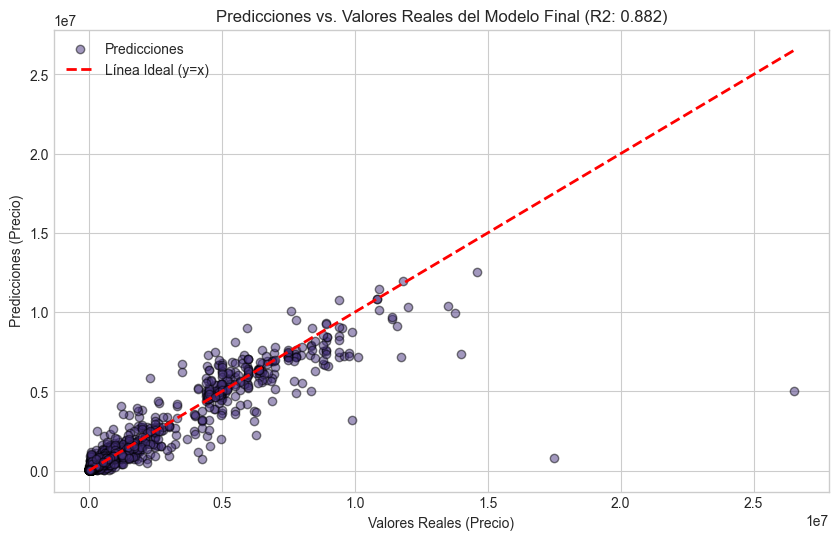

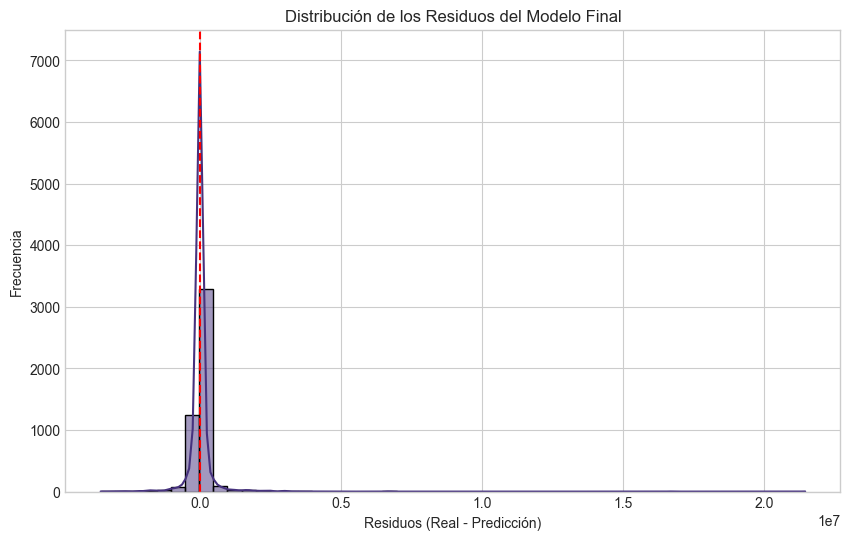

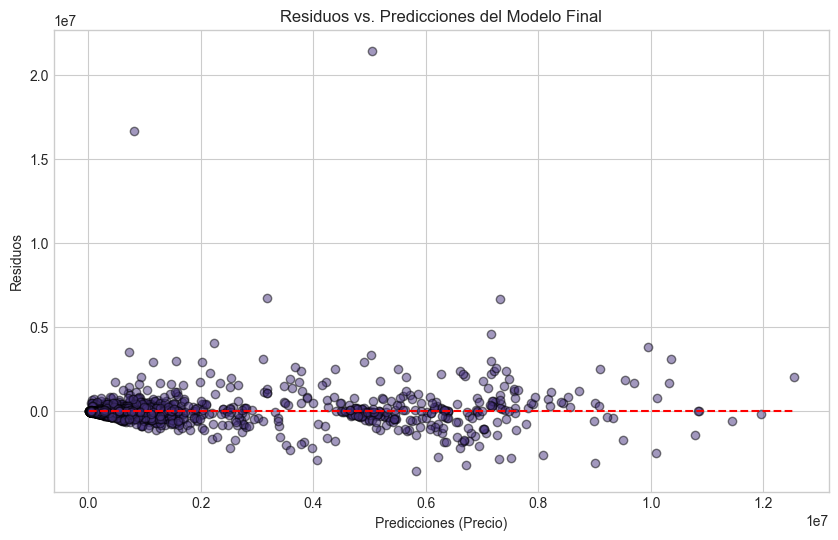

In [9]:
if final_model_pipeline is not None and not X_test.empty and not y_test.empty:
    print("Evaluando el modelo final en el conjunto de prueba...")
    try:
        y_pred_final = final_model_pipeline.predict(X_test)
        
        mse_final = mean_squared_error(y_test, y_pred_final)
        rmse_final = np.sqrt(mse_final)
        mae_final = mean_absolute_error(y_test, y_pred_final)
        r2_final = r2_score(y_test, y_pred_final)
        
        print("\n--- Métricas del Modelo Final en el Conjunto de Prueba ---")
        print(f"MSE: {mse_final:.2f}")
        print(f"RMSE: {rmse_final:.2f}")
        print(f"MAE: {mae_final:.2f}")
        print(f"R2 Score: {r2_final:.4f}")
        
        # Visualización de Predicciones vs. Valores Reales
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred_final, alpha=0.5, edgecolors='k', label='Predicciones')
        plt.plot([min(y_test.min(), y_pred_final.min()), max(y_test.max(), y_pred_final.max())], 
                 [min(y_test.min(), y_pred_final.min()), max(y_test.max(), y_pred_final.max())], 
                 'r--', lw=2, label='Línea Ideal (y=x)')
        plt.xlabel("Valores Reales (Precio)")
        plt.ylabel("Predicciones (Precio)")
        plt.title(f"Predicciones vs. Valores Reales del Modelo Final (R2: {r2_final:.3f})")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Análisis de Residuos
        residuos = y_test - y_pred_final
        
        plt.figure(figsize=(10, 6))
        sns.histplot(residuos, kde=True, bins=50) # Aumentar bins si hay muchos datos
        plt.xlabel("Residuos (Real - Predicción)")
        plt.ylabel("Frecuencia")
        plt.title("Distribución de los Residuos del Modelo Final")
        plt.axvline(0, color='r', linestyle='--')
        plt.grid(True)
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_final, residuos, alpha=0.5, edgecolors='k')
        plt.hlines(0, xmin=y_pred_final.min(), xmax=y_pred_final.max(), colors='r', linestyles='--')
        plt.xlabel("Predicciones (Precio)")
        plt.ylabel("Residuos")
        plt.title("Residuos vs. Predicciones del Modelo Final")
        plt.grid(True)
        plt.show()
        
    except Exception as e:
        print(f"Error durante la evaluación detallada del modelo final: {e}")
        
else:
    print("No hay un modelo final entrenado o X_test/y_test están vacíos. No se puede realizar la evaluación detallada.")

## 10. Análisis de Importancia de Características del Modelo Final
Extraer la importancia de las características del modelo final. Si el regresor en el pipeline tiene el atributo `feature_importances_` (ej. RandomForest, GradientBoosting), obtener estos valores. Si tiene `coef_` (ej. LinearRegression, Lasso, Ridge), obtener estos coeficientes. Utilizar `get_feature_names_out()` del preprocesador para obtener los nombres de las características transformadas (incluyendo las generadas por OneHotEncoder). Crear un DataFrame con los nombres de las características y su importancia/coeficiente. Visualizar las características más importantes en un gráfico de barras. Considerar el uso de SHAP para un análisis más profundo y agnóstico al modelo si es necesario.


--- Importancia de Características (del modelo) ---


,feature,importance
0,num__superficie,0.32
3,num__latitud,0.24
2,num__baños,0.20
4,num__longitud,0.12
1,num__habitaciones,0.08
7,cat__tipo_propiedad_chalet,0.01
10,cat__tipo_propiedad_piso,0.01
6,cat__tipo_propiedad_casa_rural,0.00
18,cat__provincia_Málaga,0.00
14,cat__provincia_Desconocida,0.00


C:\Users\danie\AppData\Local\Temp\ipykernel_53036\2272244528.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')


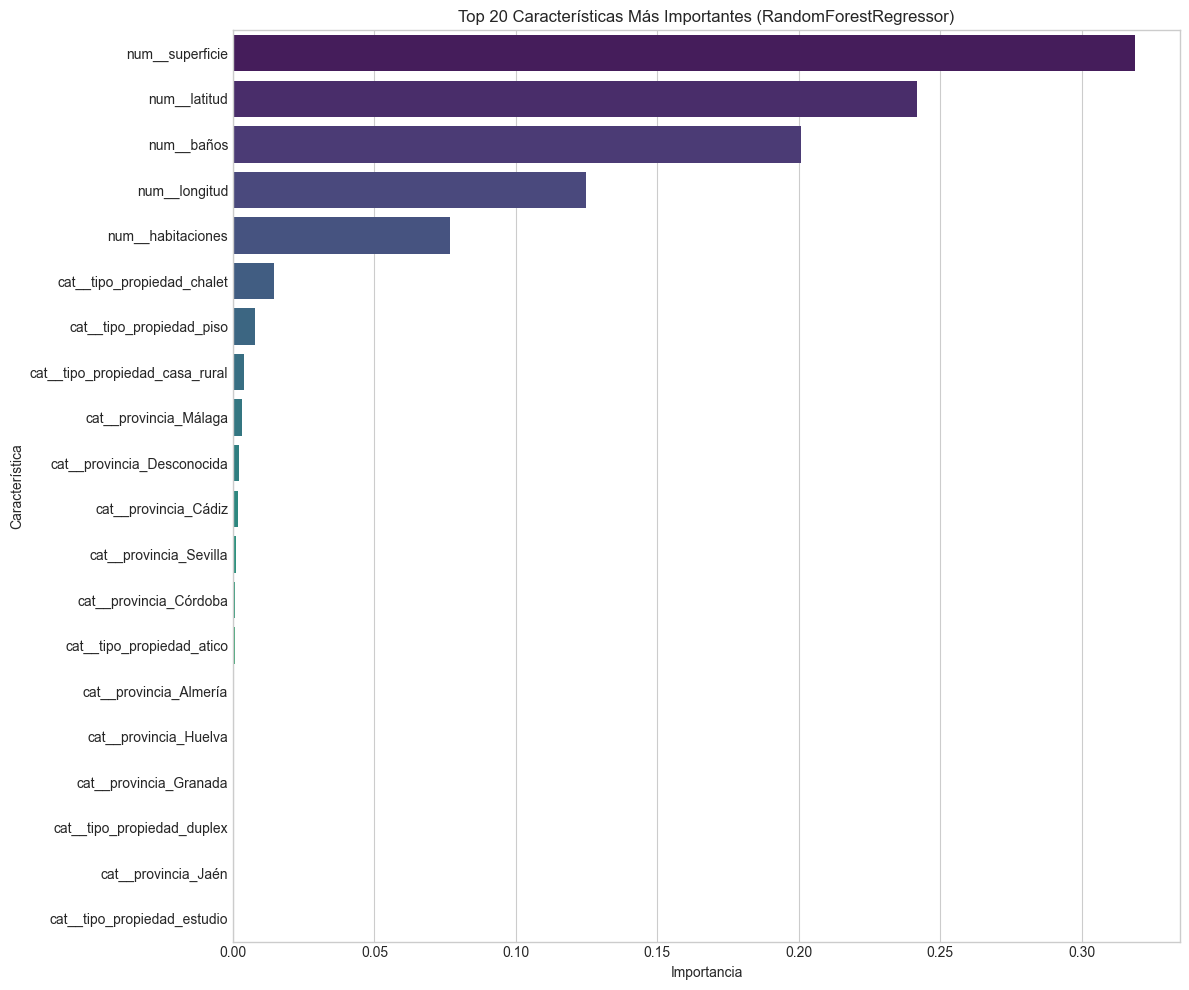

In [10]:
if final_model_pipeline is not None:
    try:
        # Acceder al preprocesador y al modelo dentro del pipeline
        preprocessor_fitted = final_model_pipeline.named_steps.get('preprocessor')
        regressor_fitted = final_model_pipeline.named_steps.get('regressor')

        if preprocessor_fitted is None or regressor_fitted is None:
            print("Error: No se pudo acceder al preprocesador o al regresor en el pipeline final.")
        else:
            # Obtener los nombres de las características después del preprocesamiento
            feature_names_transformed = []
            try:
                if hasattr(preprocessor_fitted, 'get_feature_names_out'):
                    feature_names_transformed = list(preprocessor_fitted.get_feature_names_out())
                else: # Fallback para versiones antiguas de scikit-learn
                    print("Advertencia: get_feature_names_out no disponible en el preprocesador. Intentando inferir nombres.")
                    for name, trans, cols in preprocessor_fitted.transformers_:
                        if trans == 'drop' or trans == 'passthrough':
                            if trans == 'passthrough': # Si es passthrough, los nombres son las columnas originales
                                feature_names_transformed.extend(cols)
                            continue # Skip 'drop'
                        # Para transformadores dentro de Pipelines (como numeric_transformer)
                        if isinstance(trans, Pipeline):
                            # Intentar obtener nombres del último paso del sub-pipeline (e.g., onehot)
                            final_step_in_subpipeline = trans.steps[-1][1]
                            if hasattr(final_step_in_subpipeline, 'get_feature_names_out'):
                                feature_names_transformed.extend(final_step_in_subpipeline.get_feature_names_out(cols))
                            elif hasattr(final_step_in_subpipeline, 'get_feature_names'): # Para OneHotEncoder más antiguo
                                feature_names_transformed.extend(final_step_in_subpipeline.get_feature_names(cols))
                            else: # Para escaladores u otros que no cambian el número de características
                                feature_names_transformed.extend(cols)
                        # Para transformadores directos (como OneHotEncoder si no está en un sub-pipeline)
                        elif hasattr(trans, 'get_feature_names_out'):
                             feature_names_transformed.extend(trans.get_feature_names_out(cols))
                        elif hasattr(trans, 'get_feature_names'): 
                             feature_names_transformed.extend(trans.get_feature_names(cols))
                        else: # Para escaladores, imputers que no cambian nombres ni número de features
                            feature_names_transformed.extend(cols)
                    if not feature_names_transformed:
                         print("No se pudieron inferir los nombres de las características transformadas.")

            except Exception as e_fn:
                print(f"Error obteniendo nombres de características: {e_fn}")
            
            if not feature_names_transformed:
                print("No se pudieron obtener los nombres de las características transformadas. El análisis de importancia puede no ser interpretable.")
                # Podríamos intentar usar índices numéricos si los nombres fallan, pero es menos útil.

            if hasattr(regressor_fitted, 'feature_importances_'):
                importances = regressor_fitted.feature_importances_
                
                if len(feature_names_transformed) != len(importances) and feature_names_transformed:
                    print(f"Advertencia: Discrepancia en longitud de nombres ({len(feature_names_transformed)}) e importancias ({len(importances)}). Usando índices.")
                    feature_display_names = [f"Feature {i}" for i in range(len(importances))]
                elif not feature_names_transformed:
                    feature_display_names = [f"Feature {i}" for i in range(len(importances))]
                else:
                    feature_display_names = feature_names_transformed

                feature_importance_df = pd.DataFrame({
                    'feature': feature_display_names,
                    'importance': importances
                }).sort_values(by='importance', ascending=False)
                
                print("\n--- Importancia de Características (del modelo) ---")
                display(feature_importance_df.head(20)) # Mostrar las 20 más importantes
                
                plt.figure(figsize=(12, 10)) # Aumentar tamaño para mejor visualización
                sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')
                plt.title(f'Top 20 Características Más Importantes ({type(regressor_fitted).__name__})')
                plt.xlabel('Importancia')
                plt.ylabel('Característica')
                plt.tight_layout()
                plt.show()

            elif hasattr(regressor_fitted, 'coef_'):
                coefficients = regressor_fitted.coef_
                
                if len(feature_names_transformed) != len(coefficients) and feature_names_transformed:
                    print(f"Advertencia: Discrepancia en longitud de nombres ({len(feature_names_transformed)}) y coeficientes ({len(coefficients)}). Usando índices.")
                    feature_display_names = [f"Feature {i}" for i in range(len(coefficients))]
                elif not feature_names_transformed:
                    feature_display_names = [f"Feature {i}" for i in range(len(coefficients))]
                else:
                    feature_display_names = feature_names_transformed

                feature_coeffs_df = pd.DataFrame({
                    'feature': feature_display_names,
                    'coefficient': coefficients
                })
                # Ordenar por valor absoluto del coeficiente para ver magnitud de importancia
                feature_coeffs_df['abs_coefficient'] = feature_coeffs_df['coefficient'].abs()
                feature_coeffs_df = feature_coeffs_df.sort_values(by='abs_coefficient', ascending=False).drop(columns=['abs_coefficient'])

                print("\n--- Coeficientes de Características (Modelos Lineales) ---")
                display(feature_coeffs_df.head(20))

                plt.figure(figsize=(12, 10)) # Aumentar tamaño
                sns.barplot(x='coefficient', y='feature', data=feature_coeffs_df.head(20), palette='coolwarm')
                plt.title(f'Top 20 Coeficientes de Características ({type(regressor_fitted).__name__})')
                plt.xlabel('Coeficiente')
                plt.ylabel('Característica')
                plt.axvline(0, color='black', lw=0.8) # Línea en cero para referencia
                plt.tight_layout()
                plt.show()
                
            else:
                print(f"El modelo {type(regressor_fitted).__name__} no tiene un atributo 'feature_importances_' o 'coef_' estándar.")
                print("Considere usar SHAP para un análisis de importancia más general.")
                # Ejemplo de cómo se podría iniciar SHAP (requiere instalación y datos preprocesados):
                # import shap
                # # Necesitaríamos X_train_processed y X_test_processed
                # # X_train_processed = preprocessor_fitted.transform(X_train) 
                # # X_test_processed = preprocessor_fitted.transform(X_test)
                #
                # # if isinstance(regressor_fitted, (RandomForestRegressor, GradientBoostingRegressor, DecisionTreeRegressor)):
                # #     explainer = shap.TreeExplainer(regressor_fitted, X_train_processed) # Pasar datos de entrenamiento para algunos explainers
                # #     shap_values = explainer.shap_values(X_test_processed) # Calcular para el conjunto de prueba
                # #     shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names_transformed)
                # # else: # Para otros modelos, puede ser KernelExplainer (más lento)
                # #     # KernelExplainer puede ser lento, usar una muestra de X_train_processed para el background
                # #     background_sample = shap.sample(X_train_processed, min(100, X_train_processed.shape[0])) 
                # #     explainer = shap.KernelExplainer(regressor_fitted.predict, background_sample)
                # #     shap_values = explainer.shap_values(X_test_processed)
                # #     shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names_transformed)

    except Exception as e:
        print(f"Error durante el análisis de importancia de características: {e}")
        import traceback
        traceback.print_exc()
else:
    print("No hay un modelo final disponible para analizar la importancia de características.")


## 11. Guardado del Modelo Final para Despliegue
Definir una ruta y nombre de archivo para el modelo final (ej. 'final_housing_price_model_andalucia.joblib'). Utilizar `joblib.dump` para serializar y guardar el pipeline completo del modelo final (que incluye el preprocesador ajustado y el regresor entrenado con los hiperparámetros óptimos) en disco. Esto permitirá cargar y reutilizar el modelo en otros entornos o aplicaciones.

In [11]:
if final_model_pipeline is not None:
    # Definir la ruta y el nombre del archivo para guardar el modelo
    # Guardarlo en una carpeta 'models' dentro del directorio base del proyecto
    try:
        if 'base_dir' not in globals() or not os.path.exists(base_dir):
            # Si base_dir no está definido (ej. si la celda 1 falló parcialmente) o no es válido
            # intentar usar el directorio actual del notebook como base para 'models'
            print("Advertencia: 'base_dir' no está bien definido o no existe. Intentando guardar en 'models' relativo al notebook.")
            current_notebook_dir_for_model = os.getcwd() # Directorio del notebook
            models_dir = os.path.join(current_notebook_dir_for_model, '..', 'models') # Subir un nivel y luego a 'models'
            models_dir = os.path.abspath(models_dir) # Normalizar la ruta
            if not os.path.exists(os.path.dirname(models_dir)): # Si el directorio padre de 'models' no existe
                 models_dir = os.path.join(current_notebook_dir_for_model, 'models') # Crear 'models' en el dir del notebook
                 models_dir = os.path.abspath(models_dir)


        else: # base_dir está definido y es plausible
            models_dir = os.path.join(base_dir, 'models')

        if not os.path.exists(models_dir):
            os.makedirs(models_dir)
            print(f"Directorio '{models_dir}' creado.")
            
        model_filename = 'final_housing_price_model_andalucia_v2.joblib'
        model_path_to_save = os.path.join(models_dir, model_filename)
        
        joblib.dump(final_model_pipeline, model_path_to_save)
        print(f"Modelo final guardado exitosamente en: {model_path_to_save}")
        
        # Ejemplo de cómo cargarlo después:
        # print("\nPara cargar el modelo más tarde:")
        # print(f"loaded_model_pipeline = joblib.load('{model_path_to_save}')")
        # print("Para usarlo:")
        # print("# new_data = pd.DataFrame(...) # Nuevos datos con el mismo formato que X_train original (antes de preprocesar)")
        # print("# predictions = loaded_model_pipeline.predict(new_data)")
        
    except NameError: # Específicamente para base_dir si no se definió
        print("Error: 'base_dir' no está definido. No se puede determinar la ruta para guardar el modelo.")
        print("Asegúrate de que la celda de carga de datos (Celda 1) se ejecutó correctamente y definió 'base_dir'.")
        print("Intentando guardar en el directorio actual...")
        try:
            model_filename = 'final_housing_price_model_andalucia_local.joblib'
            joblib.dump(final_model_pipeline, model_filename)
            print(f"Modelo guardado localmente como '{model_filename}' debido a error con base_dir.")
        except Exception as e_local_save:
            print(f"No se pudo guardar localmente: {e_local_save}")

    except Exception as e:
        print(f"Error al guardar el modelo: {e}")
else:
    print("No hay un modelo final entrenado para guardar.")

Modelo final guardado exitosamente en: c:\Users\danie\Desktop\Universidad\TFG---Predictor-Precios-Vivienda-Andalucia\models\final_housing_price_model_andalucia_v2.joblib


## Conclusiones y Próximos Pasos

En este cuaderno, hemos desarrollado un pipeline completo para predecir los precios de las viviendas en Andalucía.
1.  Cargamos y exploramos inicialmente los datos.
2.  Realizamos ingeniería de características para extraer la 'provincia'.
3.  Preprocesamos los datos numéricos (incluyendo latitud/longitud) y categóricos.
4.  Implementamos clustering K-Means para segmentación de mercado (la característica 'cluster' no se usó en el modelo final por simplicidad, pero podría explorarse).
5.  Dividimos los datos en conjuntos de entrenamiento y prueba.
6.  Entrenamos y evaluamos varios modelos de regresión.
7.  Optimizamos los hiperparámetros del modelo más prometedor usando RandomizedSearchCV.
8.  Validamos el modelo usando validación cruzada explícita.
9.  Evaluamos el rendimiento del modelo final en el conjunto de prueba, incluyendo análisis de residuos.
10. Analizamos la importancia de las características del modelo final.
11. Guardamos el modelo final para su posible despliegue.

**Resultados Clave:**
*   (Aquí se resumirían las métricas del modelo final, ej. R², MAE, RMSE en el conjunto de prueba).
*   (Se mencionarían las características más importantes encontradas).

**Próximos Pasos Potenciales:**
*   **Mejorar la ingeniería de características:**
    *   Explorar transformaciones más complejas (ej. logaritmos para 'precio' o 'superficie' si su distribución es sesgada).
    *   Crear interacciones entre características.
    *   Utilizar datos geoespaciales de forma más directa (ej. distancia a puntos de interés, densidad poblacional, etc.).
    *   Incorporar la característica 'cluster' en el modelo de regresión y evaluar su impacto, ajustando el preprocesador correspondientemente.
*   **Probar modelos más avanzados:**
    *   Considerar ensambles más potentes como XGBoost, LightGBM, o CatBoost.
    *   Explorar redes neuronales más profundas si el volumen de datos y la complejidad del problema lo justifican.
*   **Análisis de errores más profundo:**
    *   Investigar los casos donde el modelo comete errores significativos (residuos grandes) para entender sus limitaciones y posibles sesgos.
*   **Despliegue del modelo:**
    *   Crear una API (e.g., con Flask o FastAPI) para servir predicciones.
    *   Desarrollar una interfaz de usuario simple para interactuar con el modelo.
*   **Monitorización del modelo:**
    *   Una vez desplegado, monitorizar su rendimiento en datos nuevos (data drift, concept drift).
    *   Reentrenar el modelo periódicamente o cuando su rendimiento decaiga.
*   **Refinar la extracción de 'provincia':** Aunque el mapa es extenso, siempre puede haber casos no cubiertos. Mejorar la robustez de esta extracción o usar datos de códigos postales si estuvieran disponibles y fueran fiables.
*   **Tratamiento de outliers:** Investigar el impacto de valores atípicos en las características y el precio, y considerar estrategias para manejarlos si afectan negativamente al modelo.